# Combine results from multiple ERDDAPs

In this notebook we use data from one ERDDAP (OSMC animal-borne sensors) to make subsequent queries to other ERDDAPs supplying Argo and satellite data

In [1]:
import datetime
import pandas as pd
from erddapy import ERDDAP
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


def cartopy_map(lon, lat):
    central_lon = (lon.min() + lon.max())/2
    central_lat = (lat.min() + lat.max())/2
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(projection=ccrs.AzimuthalEquidistant(central_latitude=central_lat, central_longitude=central_lon))
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.gridlines(color="k", alpha=0.2)
    return ax

### 1. MEOPS animals

We can use ERDDAP's built in search function to find datasets that match a keyword. Let's find some animal borne sensor data

In [2]:
e_osmc = ERDDAP(
    server="https://osmc.noaa.gov/erddap",
    protocol="tabledap"
)
url = e_osmc.get_search_url(search_for="animal", response="csv")

animals = pd.read_csv(url)
animals[["Dataset ID", "Title", "Summary"]]

,Dataset ID,Title,Summary
0,MEOP_profiles,"MEOP animal profiles, v2024","MEOP animal profiles, v2024\n\ncdm_data_type =..."
1,anibos_movement_data,AniBOS movement data,Animal Borne Ocean Sensor movement data\n\ncdm...


In [3]:
e_osmc.dataset_id = animals["Dataset ID"][0]
e_osmc.variables = ['species']
species = e_osmc.to_pandas()
species

,species
0,Australian sea lion
1,Bearded seal
2,Blueback hooded
3,Bluebacks
4,California sea lion
5,Crabeater seal
6,Flatback turtle
7,Fur seal
8,Green turtle
9,Grey


In [4]:
e_osmc.constraints = {
    "species=": "Southern elephant seal",
    "longitude>=": -90,
    "longitude<=": -60,
    "latitude<=": -60
}

e_osmc.variables = ["latitude", "longitude", "time", "species"]
df = e_osmc.to_pandas()
df

,latitude (degrees_north),longitude (degrees_east),time (UTC),species
0,-63.3936,-60.0573,2008-02-13T23:00:00Z,Southern elephant seal
1,-63.3901,-60.5138,2008-02-14T04:20:00Z,Southern elephant seal
2,-63.5603,-61.0764,2008-02-14T09:40:00Z,Southern elephant seal
3,-63.6047,-61.9847,2008-02-14T21:50:00Z,Southern elephant seal
4,-63.7078,-62.5313,2008-02-15T02:10:00Z,Southern elephant seal
...,...,...,...,...
35340,-62.1209,-60.4423,2005-11-21T16:20:00Z,Southern elephant seal
35341,-62.5409,-60.8988,2005-11-25T11:30:00Z,Southern elephant seal
35342,-62.2985,-60.9728,2005-11-25T16:40:00Z,Southern elephant seal
35343,-62.2816,-62.6380,2005-11-26T16:10:00Z,Southern elephant seal


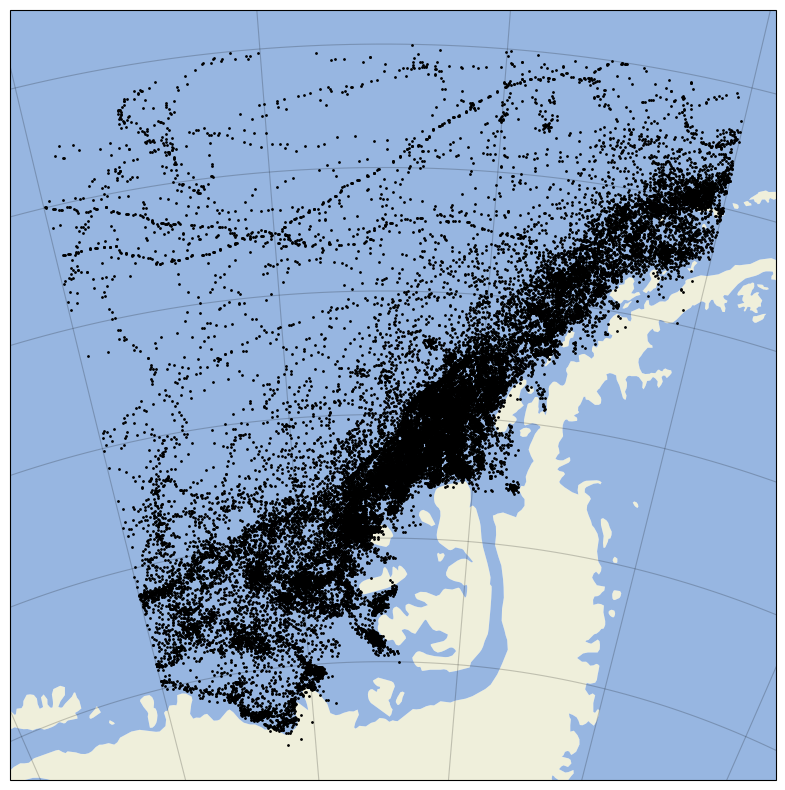

In [5]:
ax = cartopy_map(
    df["longitude (degrees_east)"],
    df["latitude (degrees_north)"],
)

ax.scatter(
    df["longitude (degrees_east)"],
    df["latitude (degrees_north)"],
    transform=ccrs.PlateCarree(),
    color="k",
    s=1,
)

### 2. Add argo data

We use a bounding box from the lon, lat and time of the seal data to look for co-located Argo floats on the ifremer ERDDAP

In [6]:
e_ifremer = ERDDAP(
    server="https://erddap.ifremer.fr/erddap",
    protocol="tabledap",
)

e_ifremer.dataset_id = "ArgoFloats"

In [7]:
e_ifremer.constraints = {
    "time>=": df["time (UTC)"].min(),
    "time<=": df["time (UTC)"].max(),
    "latitude>=": df["latitude (degrees_north)"].min(),
    "latitude<=": df["latitude (degrees_north)"].max(),
    "longitude>=": df["longitude (degrees_east)"].min(),
    "longitude<=": df["longitude (degrees_east)"].max(),
}

e_ifremer.variables = ["latitude", "longitude", "time"]

In [8]:
df_argo = e_ifremer.to_pandas()
df_argo

,latitude (degrees_north),longitude (degrees_east),time (UTC)
0,-61.143,-67.214,2012-03-15T13:15:47Z
1,-61.036,-66.298,2012-03-25T22:42:40Z
2,-60.922,-65.557,2012-04-04T22:47:31Z
3,-60.659,-65.147,2012-04-14T22:59:01Z
4,-60.344,-67.970,2012-03-15T20:53:00Z
...,...,...,...
2056,-60.575,-60.798,2014-10-02T18:45:39Z
2057,-60.241,-89.388,2010-06-28T02:24:10Z
2058,-60.513,-88.959,2010-07-08T02:29:14Z
2059,-60.406,-85.955,2010-10-05T23:39:04Z


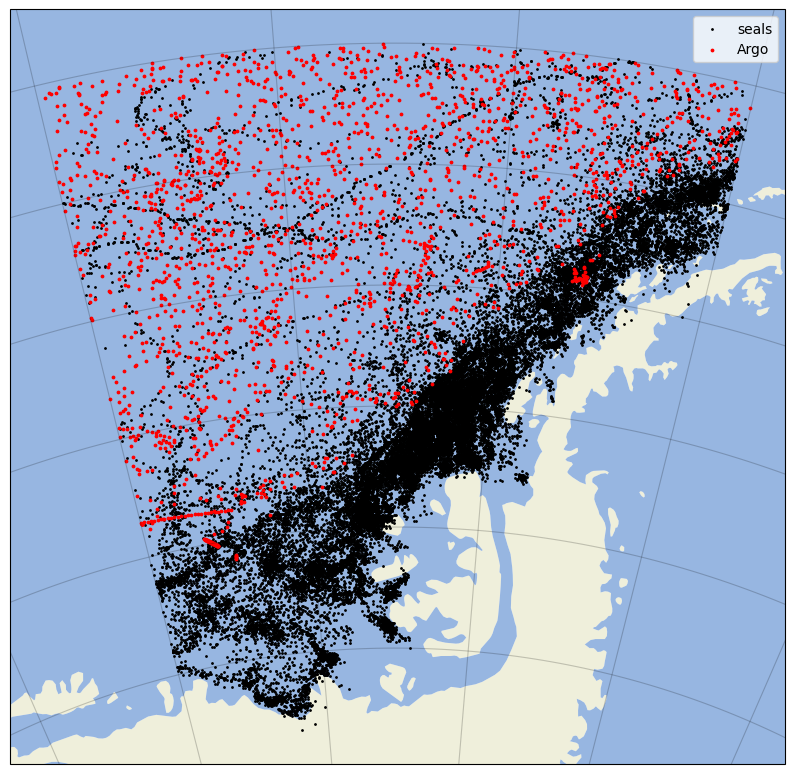

In [9]:
ax = cartopy_map(
    df["longitude (degrees_east)"],
    df["latitude (degrees_north)"]
)

ax.scatter(
    df["longitude (degrees_east)"],
    df["latitude (degrees_north)"],
    transform=ccrs.PlateCarree(),
    color="black",
    s=1,
    label="seals",
)

ax.scatter(
    df_argo["longitude (degrees_east)"],
    df_argo["latitude (degrees_north)"],
    transform=ccrs.PlateCarree(),
    color="red",
    s=3,
    label="Argo",
)

ax.legend()

---------------------------
### References

MEOP data from https://meop.net

Argo data from ifremer https://erddap.ifremer.fr/erddap/tabledap/ArgoFloats.html

More info on using ERDDAP's inbuilt search https://ioos.github.io/erddapy/01b-tabledap-output.html